# Overview

Sequential models like(RNNs) were used in many machine learning tasks involving sequence data. Their inherent sequential structure hindered the speed of computation since each step depended on a hidden state from the last time step. Other techniques like passing the ground truth information(teacher forcing) to the input of the next time step were used to speed up training, but these techniques sometimes had a negative effect on the capacity of the model to generalise.

The Attention mechanism was introduced to make these sequence models more robust as they suffered from a vanishing gradient problem relative to the length of the sequence. This Enhanced the performance of sequence to sequence architectures on complex tasks such as machine translation.

The transformer was first introduced in 2017 in the paper (attention is all you need). Replacing the sequence modeling completely by the multi-head self attention mechanism.

# Positional encodings

The position of words is inherently encoded in the architecture of sequence models since the computation is done in time steps.


<div align="center">
    <img src="images/pos_encoding.PNG" width=220 height=300 alt="positional encoding - original transformer">
</div>

The position of words is an important piece of information for a language model, as the same word can have a different meaning depending on its position in the sequence; the meaning of the entire phrase can change if this information is not encoded in the model

In the original transformer paper, positional encodings were introduced to model this information.

### position vector:

The authors of the original transformer paper proposed a vector $p_t^i$ of size $d$ where $d$ is an even number representing the encoding position.


$p_t^{2k+1} = cos(w_k.t)$     and    $p_t^{2k} = sin(w_k.t)$    where :    $\omega_k = \frac{1}{10000^{2k/d}}$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
d, seq_len, nw = 512, 2048, 10000

In [ ]:
p = np.zeros((seq_len, d))

In [ ]:
for k in range(seq_len):
    for i in np.arange(d//2):
        div = np.power(nw, 2*i/d)
        p[k, 2*i] = np.sin(k/div)
        p[k, 2*i+1] = np.cos(k/div)

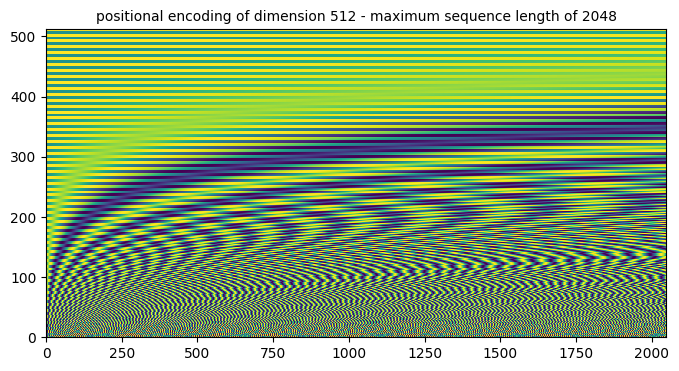

In [ ]:
plt.figure(figsize=(8,4))
plt.pcolormesh(p.T)
plt.title("positional encoding of dimension 512 - maximum sequence length of 2048", fontsize=10, fontweight=10)
plt.show()

the distance between neighboring time-steps and changes nicely with time. Here is an illustration from the tensorflow official impelmentation

In [ ]:
pos_encoding = p

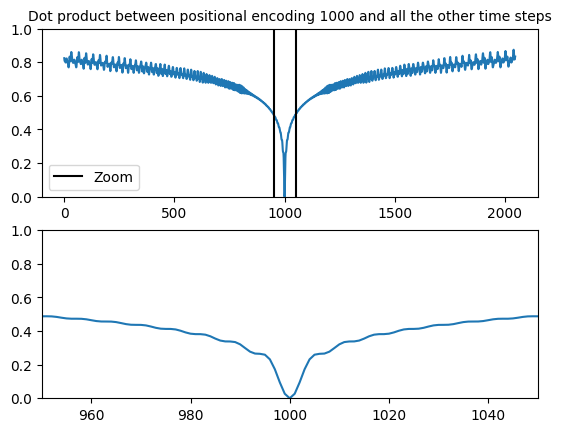

In [ ]:
from numpy import linalg as LA

pos_encoding/=LA.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = np.dot(pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(1 - dots)
plt.ylim([0,1])
plt.title("Dot product between positional encoding 1000 and all the other time steps", fontsize=10, fontweight=10)
plt.plot([950, 950, float('nan'), 1050, 1050],[0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(1 - dots)
plt.xlim([950, 1050])
plt.ylim([0,1])
plt.show()

# Transformer / GPT 1 : Dataset for translation / next token prediction

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
from utils.config import Nx, hidden

In [ ]:
hidden, Nx

(1000, 4)

In [ ]:
!git clone https://github.com/moatazaymane/pytorch-transformer.git

Cloning into 'pytorch-transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 49 (delta 12), reused 44 (delta 9), pack-reused 0
Receiving objects: 100% (49/49), 880.68 KiB | 14.68 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
import os
os.chdir("/content/pytorch-transformer/GPT_1")
os.getcwd()

'/content/pytorch-transformer/GPT_1'

In [ ]:
%%capture
!cd books
!cat books/*.txt > books/gpt_training.txt

In [ ]:
os.getcwd()

'/content/pytorch-transformer/GPT_1'

In [ ]:
from google.colab import drive
drive.mount('/content/pytorch-transformer/GPT_1/drive')

Mounted at /content/pytorch-transformer/GPT_1/drive


In [ ]:
!ls -a "drive/My Drive/colab datasets/en-fr.csv/en-fr.csv/"

ls: cannot access 'drive/My Drive/colab datasets/en-fr.csv/en-fr.csv/': No such file or directory


In [ ]:
!unzip "drive/My Drive/colab datasets/en-fr.csv/en-fr.csv.zip" -d "drive/My Drive/colab datasets/en-fr.csv/"

Archive:  drive/My Drive/colab datasets/en-fr.csv/sample.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of drive/My Drive/colab datasets/en-fr.csv/sample.csv or
        drive/My Drive/colab datasets/en-fr.csv/sample.csv.zip, and cannot find drive/My Drive/colab datasets/en-fr.csv/sample.csv.ZIP, period.


In [ ]:
%%capture
!python -m pip install --upgrade pip
!pip install tailer

In [ ]:
!pip install --upgrade tailer

/bin/bash: line 1: pip: command not found


In [ ]:
import tailer

In [ ]:
import pandas as pd

#df1 = pd.read_csv("drive/MyDrive/colab datasets/en-fr.csv/clean_en_fr_sentences.csv", nrows=4000000)
df2 = pd.read_csv("drive/MyDrive/colab datasets/en-fr.csv/sample.csv")

In [ ]:
df2['num_words_en'] = df2.en.progress_apply(lambda x: len(str(x).split(" ")))
df2['num_words_fr'] = df2.fr.progress_apply(lambda x: len(str(x).split(" ")))

100%|██████████| 4000000/4000000 [00:19<00:00, 201630.23it/s]


In [ ]:
df2['num_words_en'].describe()

count    4.000000e+06
mean     3.029729e+01
std      3.144402e+01
min      1.000000e+00
25%      1.600000e+01
50%      2.500000e+01
75%      3.700000e+01
max      1.325300e+04
Name: num_words_en, dtype: float64

In [ ]:
df2['num_words_fr'].describe()

count    4.000000e+06
mean     3.509626e+01
std      4.060232e+01
min      1.000000e+00
25%      1.900000e+01
50%      2.900000e+01
75%      4.300000e+01
max      1.213500e+04
Name: num_words_fr, dtype: float64

In [ ]:
df2_c = df2[(df2.num_words_en > 10) & (df2.num_words_en < 50)]

In [ ]:
import re

punc = '''!()-[]{};:'"\,<>./|?@#$%^&*_~1234567890<>>»—«'''


def clean_text(row):

  text = str(row.en)


  for sp in punc:
    if sp in text:
      text = text.replace(sp, "")

  text = re.sub("\s{2,}"," ", text)
  text = text.strip()
  return text


def clean_text_fr(row):

  text = str(row.fr)


  for sp in punc:
    if sp in text:
      text = text.replace(sp, "")

  text = re.sub("\s{2,}"," ", text)
  text = text.strip()
  return text

In [ ]:
df2_c.en = df2_c.progress_apply(clean_text, axis=1)

100%|██████████| 3092308/3092308 [01:13<00:00, 41985.10it/s]
<ipython-input-30-5b907eb83fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_c.en = df2_c.progress_apply(clean_text, axis=1)


In [ ]:
df2_c.fr = df2_c.progress_apply(clean_text_fr, axis=1)

100%|██████████| 3092308/3092308 [01:18<00:00, 39417.07it/s]
<ipython-input-32-1b23f0fd54d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_c.fr = df2_c.progress_apply(clean_text_fr, axis=1)


In [ ]:
df2_c['num_words_clean_en'] = df2_c.en.progress_apply(lambda x: len(str(x).split(" ")))
df2_c['num_words_clean_fr'] = df2_c.fr.progress_apply(lambda x: len(str(x).split(" ")))

100%|██████████| 3092308/3092308 [00:08<00:00, 367104.01it/s]
<ipython-input-33-e6334ca63ad2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_c['num_words_clean_en'] = df2_c.en.progress_apply(lambda x: len(str(x).split(" ")))
100%|██████████| 3092308/3092308 [00:11<00:00, 268705.42it/s]
<ipython-input-33-e6334ca63ad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_c['num_words_clean_fr'] = df2_c.fr.progress_apply(lambda x: len(str(x).split(" ")))


In [ ]:
df2_c.en.tail().iloc[3]

'Overall the results confirm the unsatisfactory prognosis of the yield per recruit model and emphasise the need to gain an understanding of the biological factors determining the shape of the lobster stock–recruitment curve'

In [ ]:
df2_c.fr.tail().iloc[3]

'Dans lensemble les résultats confirment le pronostic défavorable du modèle de la production par recrue et soulignent la nécessité de mieux comprendre les facteurs biologiques qui déterminent la forme de la courbe stock–recrutement chez le homard'

In [ ]:
df2_c.en.shape

(3092308,)

In [ ]:
count = df2_c['num_words_clean_en'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df2_c.num_words_clean_en.describe()

count    3.092308e+06
mean     2.492606e+01
std      9.738971e+00
min      1.000000e+00
25%      1.700000e+01
50%      2.400000e+01
75%      3.200000e+01
max      6.100000e+01
Name: num_words_clean_en, dtype: float64

In [ ]:
df2_clean = df2_c[df2_c.num_words_clean_en > 9]

In [ ]:
count = df2_clean['num_words_clean_en'].value_counts()

## Number of words in english sentences - first dataset

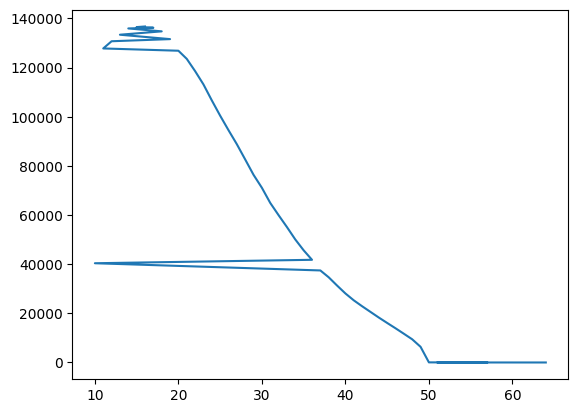

In [ ]:
plt.plot(count)

## Number of words in english sentences - first dataset

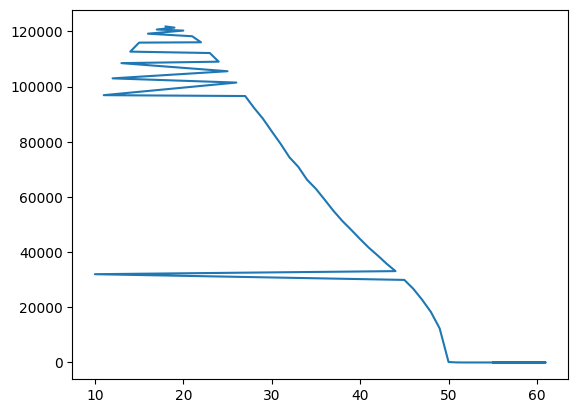

In [ ]:
plt.plot(count)

In [ ]:
df2_clean.to_csv("drive/My Drive/colab datasets/en-fr.csv/clean_en_fr_sentences_2.csv", index=False)

## Reading dataset from Drive

In [ ]:
!ls "drive/My Drive/colab datasets/en-fr.csv/"

ls: cannot access 'drive/My Drive/colab datasets/en-fr.csv/': No such file or directory


In [ ]:
import os
import pandas as pd
os.getcwd()

'/content/pytorch-transformer/GPT_1'

In [ ]:
df_ = pd.read_csv("drive/My Drive/colab datasets/en-fr.csv/clean_en_fr_sentences_2.csv")

In [ ]:
%%capture
!pip install tokenizers
!pip install loguru
!pip install datasets
!pip install seaborn
!pip install torcheval
!pip install tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
os.getcwd()

'/content/pytorch-transformer/GPT_1'

In [ ]:
import torch.optim
import re
from datasets import load_dataset
from tqdm import tqdm
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torcheval.metrics import Perplexity
from random import randint
import os
from loguru import logger
from utils.config import (tokenizer_path,context_size, tokenizer_name, train_size, train_batch_size, val_batch_size,
                          width, hidden, h, num_epochs, Nx, learning_rate, model_name, load_pretrained, model_path)
from Dataset.dataset import GPTDataset
from torch.utils.data import DataLoader
from GPT import Instantiate_GPT


def write_msg(msg, iterator):
    iterator.write(msg)
    return


def get_next_token_greedy(gpt_model, inp, mask, device):

    inp = inp.to(dtype=torch.int64)
    mask = mask.to(dtype=torch.int64)
    next_token_probabilities = gpt_model.forward(inp.to(device), mask.to(device))
    _, next_token = torch.max(next_token_probabilities, dim=2)
    return next_token


def validate(gpt_model, dataloader_val, tokenizer, write, iterator, device):

    gpt_model.eval()
    y_true, yhat = [], []

    console_width = 70

    with torch.no_grad():
        for batch in dataloader_val:
            inp = batch['input'].to(device)
            mask = batch['mask'].to(device)
            yt = batch['next_token']
            target_token = yt
            yh = get_next_token_greedy(gpt_model, inp, mask, device)
            target_text = tokenizer.decode([yt])
            predicted_text = tokenizer.decode(yh[0].detach().cpu().tolist())
            decoded_inp = tokenizer.decode(inp[0].detach().cpu().tolist())

            y_true.append(target_text)
            yhhat = predicted_text.split(' ')[-1]

            yhat.append(yhhat)

            logger.debug(f"this is ytrue {yt}")

            write('--' * console_width, iterator=iterator)
            write(f"Target text {decoded_inp} {target_text}", iterator=iterator)
            write(f"Predicted text {predicted_text}", iterator=iterator)

        correct_predictions = 0
        logger.debug(f"yhat is {yhat}")
        logger.debug(f"ytrue is {target_text}")
        for i in range(len(y_true)):
            if yhat[i] == y_true[i]:
                correct_predictions += 1
        write(f"Next token prediction accuracy {correct_predictions/len(y_true):02f}", iterator=iterator)



def get_data_translation_nxt_token():

    sentences_ds = df_.en.tolist()

    # training Tokenizer from available sentences
    if not os.path.isfile("drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2"):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        trainer = WordLevelTrainer(show_progress=True, special_tokens=["[UNK]", "[PAD]"],
                                   min_frequency=2)
        tokenizer.pre_tokenizer = Whitespace()
        logger.info(f"Training tokenizer: drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")
        tokenizer.train_from_iterator(sentences_ds, trainer=trainer)
        logger.info(f"Saving tokenizer to path: drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")
        tokenizer.save("drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")

    logger.info(f"Loading tokenizers from path: drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")
    tokenizer = Tokenizer.from_file("drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")

    max_len = 0
    ds = []
    for sentence in sentences_ds:
      sentence = sentence.strip()
      enc = tokenizer.encode(sentence).ids

      ds.append(sentence.strip())

    train_ds_, val_ds_ = ds[:int(train_size*len(sentences_ds))], sentences_ds[int(train_size*len(sentences_ds)):]

    return ds, tokenizer

def get_data_opus():

    all_ds = load_dataset("opus_books", f"en-fr")
    all_ds = all_ds['train']


    sentences_ds = []
    for el in all_ds:
      if len(el['translation']["en"].split(" ")) > 5:
        sentences_ds.append(el['translation']["en"])

    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890<>>»—«'''

    for i in range(len(sentences_ds)):

        phrase = sentences_ds[i]

        for cr in punc:
          if cr in phrase:
              phrase = phrase.replace(cr,"")
              phrase = re.sub('\s+',' ', phrase)
        phrase = re.sub("—"," ", phrase)
        sentences_ds[i] = phrase.strip()


    # training Tokenizer from available sentences
    if not os.path.isfile("tokenizer/gpt_tokenizer_1"):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        trainer = WordLevelTrainer(show_progress=True, special_tokens=["[UNK]", "[PAD]"],
                                   min_frequency=2)
        tokenizer.pre_tokenizer = Whitespace()
        logger.info(f"Training tokenizer: {tokenizer_name}")
        tokenizer.train_from_iterator(sentences_ds, trainer=trainer)
        logger.info(f"Saving tokenizer to path: {tokenizer_path}")
        tokenizer.save("tokenizer/gpt_tokenizer_1")

    logger.info(f"Loading tokenizers from path: {tokenizer_path}")
    tokenizer = Tokenizer.from_file("tokenizer/gpt_tokenizer_1")

    max_len = 0
    ds = []
    for sentence in sentences_ds:
      sentence = sentence.strip()
      enc = tokenizer.encode(sentence).ids

      ds.append(sentence.strip())

    #train_ds_, val_ds_ = ds[:int(train_size*len(sentences_ds))], sentences_ds[int(train_size*len(sentences_ds)):]

    return train_ds_, val_ds_, tokenizer

def get_data_books():


    if not os.path.isfile('books/clean_gpt_training.txt'):

      #  Preparing the dataset (text file with books)
      with open('books/gpt_training.txt', 'r', encoding="utf8") as file:
          # Read all lines to list
          lines = file.readlines()
          # Join the lines
          content = ' '.join(lines)
          # Strip the new line
          clean_content = content.replace('/\s\s+/g', ' ')
          clean_content = clean_content.replace('\n', ' ')

      punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''

      for cr in content:
          if cr in punc:
              clean_content = clean_content.replace(cr,"")

      f = open('books/clean_gpt_training.txt', "w")
      f.write(clean_content)
      f.close()


    f = open('books/clean_gpt_training.txt', "r")
    clean_content = f.read()
    f.close()

    sentences_ds = []
    L = clean_content.split(" ")
    k = randint(5,context_size)
    l =[]
    for word in tqdm(L):
        if len(word) > 0 and len(l) < k:
            l.append(word)
        elif len(word) > 0 and len(l) == k:
            sentences_ds.append(l)
            l = []
            k = randint(5, context_size)

    # training Tokenizer from available sentences
    if not os.path.isfile("tokenizer/gpt_tokenizer_1"):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        trainer = WordLevelTrainer(show_progress=True, special_tokens=["[UNK]", "[PAD]"],
                                   min_frequency=2)
        tokenizer.pre_tokenizer = Whitespace()
        logger.info(f"Training tokenizer: {tokenizer_name}")
        tokenizer.train_from_iterator(sentences_ds, trainer=trainer)
        logger.info(f"Saving tokenizer to path: drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")
        tokenizer.save("drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")

    logger.info(f"Loading tokenizers from path: {tokenizer_path}")
    tokenizer = Tokenizer.from_file("drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2")



    return sentences_ds, tokenizer

In [ ]:
context_size

10

In [ ]:
ds_, tokenizer = get_data_translation_nxt_token()

2023-12-11 23:10:34.233 | INFO     | __main__:get_data_translation_nxt_token:88 - Loading tokenizers from path: drive/My Drive/colab datasets/en-fr.csv/gpt_tokenizer_v2


In [ ]:
tokenizer.get_vocab_size()

30000

In [ ]:
next_token_dict = {}

In [ ]:
ds = []
and_count, in_count, canda_count = 0, 0, 0

for i in tqdm(range(len(ds_))):



  last_word = ds_[i].split(" ")[-1]

  if last_word != "and" and last_word != "p" and last_word!="Canada" and last_word!="in":
    id = tokenizer.encode(last_word).ids

    if id[0] != 0:
      ds.append(ds_[i])

      next_token_dict[tokenizer.decode(id)] = next_token_dict.get(tokenizer.decode(id), 0) + 1

  elif last_word == 'Canada' and canada_count < 5000:
     id = tokenizer.encode(last_word).ids
     ds.append(ds_[i])
     next_token_dict[tokenizer.decode(id)] = next_token_dict.get(tokenizer.decode(id), 0) + 1
     canada_count+=1

  elif last_word == 'and' and and_count < 5000:

     id = tokenizer.encode(last_word).ids
     ds.append(ds_[i])
     next_token_dict[tokenizer.decode(id)] = next_token_dict.get(tokenizer.decode(id), 0) + 1
     and_count+=1

  elif last_word == 'in' and in_count < 5000:

     id = tokenizer.encode(last_word).ids
     ds.append(ds_[i])
     next_token_dict[tokenizer.decode(id)] = next_token_dict.get(tokenizer.decode(id), 0) + 1
     in_count+=1

100%|██████████| 3067715/3067715 [00:34<00:00, 88902.79it/s]


In [ ]:
len(ds), len(ds_)

(2760090, 3067715)

In [ ]:
dataset_df = pd.DataFrame.from_dict(next_token_dict, orient="index", columns = ['next_token_count'])

In [ ]:
dataset_df = dataset_df.reset_index().rename(columns={"index":"next_token"})

In [ ]:
s = dataset_df[['next_token','next_token_count']].sort_values(by='next_token_count', ascending=False)

In [ ]:
s = s.head(30)

## Last token distribution : First dataset

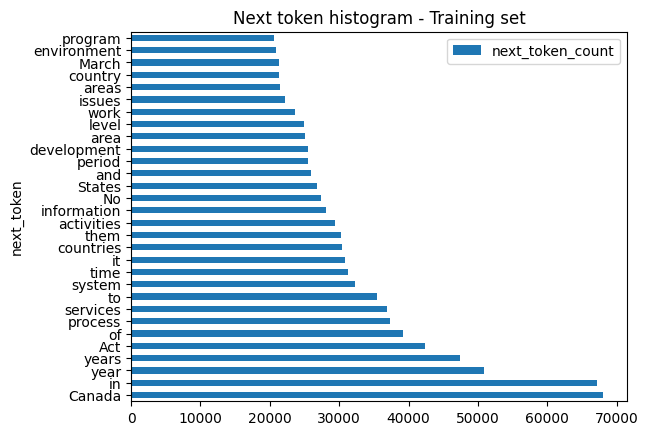

In [ ]:
import matplotlib.pyplot as plt

s.plot(kind='barh',x='next_token', title = "Next token histogram - Training set")
plt.show()

In [ ]:
train_size = 0.99

In [ ]:
len(val_ds_)

27601

In [ ]:
train_ds_, val_ds_ = ds[:int(train_size*len(ds))], ds[int(train_size*len(ds)):]

In [ ]:
train_ds = GPTDataset(tokenizer, train_ds_, context_size)

In [ ]:
val_ds = GPTDataset(tokenizer, val_ds_, context_size)

In [ ]:
train_ds[20010]

{'input': tensor([    2,  4024,     3,     0, 10010,     9,   637,    56,     6,   755]),
 'target': tensor([ 4024,     3,     0, 10010,     9,   637,    56,     6,   755,  1580]),
 'mask': tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
 'next_token': 1580,
 'sentence': '• Breakfast is the least important meal for Spanish consumers however the likelihood of skipping breakfast is lower than in North America'}

In [ ]:
train_ds[3000]

{'input': tensor([  326,  1129,   422,     4,  1617,  5307,     8, 12518,    31,    36]),
 'target': tensor([ 1129,   422,     4,  1617,  5307,     8, 12518,    31,    36,   935]),
 'mask': tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
 'next_token': 935,
 'sentence': 'To improve conditions the Moroccan government is currently working to liberalize its economy and foreign trade while keeping focused on its longterm challenges of improving education living standards and job prospects for Morocco’s youth'}

## Next token distribution, Second dataset

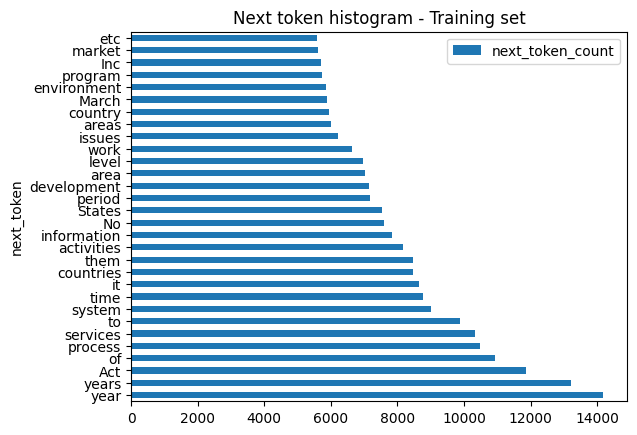

In [ ]:
import matplotlib.pyplot as plt

s.plot(kind='barh',x='next_token', title = "Next token histogram - Training set")
plt.show()

### Visualizing the next token histogram in the training dataset

In [ ]:
load_pretrained = True

In [ ]:
def train():


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_ds = GPTDataset(tokenizer, train_ds_, context_size)

    train_dataloader = DataLoader(batch_size=64, dataset=train_ds, shuffle=True)
    val_dataloader = DataLoader(batch_size=val_batch_size, dataset=val_ds)

    gpt_model = Instantiate_GPT(width=width, context_size=context_size, vocab_size=tokenizer.get_vocab_size(), h=h,
                                hidden=hidden, Nx=Nx, dropout=0.1).to(device)

    print(gpt_model)


    optimizer_gpt = torch.optim.Adam(gpt_model.parameters(), lr=learning_rate)
    objective_function = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id("[PAD]")).to(device)

    start, step = 0, 0

    if load_pretrained:
        state = torch.load("drive/My Drive/colab datasets/gpt1_v2")
        print(state.keys())
        gpt_model.load_state_dict(state['model_state_dict'])
        start = state['epoch'] + 1
        optimizer_gpt.load_state_dict(state['optimizer_state_dict'])
        step = state['global_step']

    for epoch in range(start, 20):
        gpt_model.train()
        iterator = tqdm(train_dataloader, desc=f"epoch {epoch:02d}")
        for batch in iterator:
            gpt_model.train()

            inp, mask, target = batch["input"].to(device), batch["mask"].to(device), batch["target"].to(device)
            inp = inp.to(dtype=torch.int64)
            mask = mask.to(dtype=torch.int64)
            target = target.to(dtype=torch.int64)
            output_gpt = gpt_model.forward(inp.cuda(), mask.cuda())  # (bsize, context_size, vocab_size)
            logger.debug(f"Output of gpt model is of size {output_gpt.shape}")

            loss = objective_function(output_gpt.view(-1, tokenizer.get_vocab_size()), target.view(-1))
            iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            writer.add_scalar("Loss/train", loss, epoch)


            # backprop
            loss.backward()

            # Optimizing steps
            optimizer_gpt.step()
            optimizer_gpt.zero_grad()
            step += 1

        validate(gpt_model, val_dataloader, tokenizer, write_msg, iterator, device)

        model_filename = model_name

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": gpt_model.state_dict(),
                "optimizer_state_dict": optimizer_gpt.state_dict(),
                "global_step": step
            }, "drive/My Drive/colab datasets/gpt1_v2"
        )

In [ ]:
cnt = 0
for i in range(100000):
  if (train_ds[i]['next_token']) == 0:
    cnt +=1

In [ ]:
logger.remove()
train()
writer.flush()

GPT(
  (embedding_layer): Embedding(
    (embedding_layer): Embedding(30000, 512)
  )
  (positional_encoding_layer): PosEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (projection_layer): ProjectionLayer(
    (map): Linear(in_features=512, out_features=30000, bias=True)
  )
  (decoder): Decoder(
    (decoders): ModuleList(
      (0-3): 4 x DecoderModule(
        (attention_layer): MaskedAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (WQ): Linear(in_features=512, out_features=512, bias=True)
          (WK): Linear(in_features=512, out_features=512, bias=True)
          (WV): Linear(in_features=512, out_features=512, bias=True)
          (WO): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward_layer): FeedF(
          (linear1): Linear(in_features=512, out_features=1000, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1000, out_features=512, bias=True)
          (

epoch 04: 100%|██████████| 42696/42696 [35:53<00:00, 19.83it/s, loss=0.318]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Predicted text proportion of women candidates in the last parliamentary elections of
--------------------------------------------------------------------------------------------------------------------------------------------
Target text a long time and in of the members elected were women
Predicted text long time and in of the members elected were interviewed
--------------------------------------------------------------------------------------------------------------------------------------------
Target text the fact that women have long held jobs outside the home
Predicted text fact that women have long held jobs outside the country
--------------------------------------------------------------------------------------------------------------------------------------------
Target text promoted women candidates for example by Vote for women campaigns
Predicted text women candidates for example by Vote for wom

epoch 05: 100%|██████████| 42696/42696 [36:28<00:00, 19.51it/s, loss=0.626]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Predicted text proportion of women candidates in the last parliamentary elections process
--------------------------------------------------------------------------------------------------------------------------------------------
Target text a long time and in of the members elected were women
Predicted text long time and in of the members elected were women
--------------------------------------------------------------------------------------------------------------------------------------------
Target text the fact that women have long held jobs outside the home
Predicted text fact that women have long held jobs outside the country
--------------------------------------------------------------------------------------------------------------------------------------------
Target text promoted women candidates for example by Vote for women campaigns
Predicted text women candidates for example by Vote for wome

epoch 06: 100%|██████████| 42696/42696 [37:23<00:00, 19.03it/s, loss=0.534]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Predicted text proportion of women candidates in the last parliamentary elections of
--------------------------------------------------------------------------------------------------------------------------------------------
Target text a long time and in of the members elected were women
Predicted text long time and in of the members elected were women
--------------------------------------------------------------------------------------------------------------------------------------------
Target text the fact that women have long held jobs outside the home
Predicted text fact that women have long held jobs outside the country
--------------------------------------------------------------------------------------------------------------------------------------------
Target text promoted women candidates for example by Vote for women campaigns
Predicted text women candidates for example by Vote for women onl

epoch 07: 100%|██████████| 42696/42696 [39:10<00:00, 18.17it/s, loss=0.476]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Predicted text proportion of women candidates in the last parliamentary elections of
--------------------------------------------------------------------------------------------------------------------------------------------
Target text a long time and in of the members elected were women
Predicted text long time and in of the members elected were women
--------------------------------------------------------------------------------------------------------------------------------------------
Target text the fact that women have long held jobs outside the home
Predicted text fact that women have long held jobs outside the country
--------------------------------------------------------------------------------------------------------------------------------------------
Target text promoted women candidates for example by Vote for women campaigns
Predicted text women candidates for example by Vote for women age

epoch 08:  71%|███████   | 30385/42696 [28:40<11:32, 17.78it/s, loss=0.466]

In [ ]:
writer.close()

In [ ]:
os.getcwd()

'/content/pytorch-transformer/GPT_1'

In [ ]:
!tensorboard --logdir=/content/pytorch-transformer/GPT_1/runs --bind_all

2023-11-27 20:59:31.521358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 20:59:31.521419: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 20:59:31.521458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 20:59:32.506123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.14.1 at http://44c179537f6e:60